# Model Explainability - Phase 7

**Project**: Loan Approval Decision Support System  
**Phase**: 7 - Model Explainability (Fair Models with Original Feature Mapping)  
**Date**: February 2026

## Objectives

This notebook implements comprehensive model explainability for **fair models** using a **latent-to-original feature mapping**:

1. **Latent Feature Mapping**: Map latent features back to original feature names via encoder weights
2. **Global Interpretability**: SHAP summary plots with original feature attribution
3. **Local Interpretability**: SHAP force plots, waterfall plots with original features
4. **Human-Readable Explanations**: Underwriter-friendly explanation generation

## Approach

**Problem**: Fair models use latent features (64-dim) which aren't interpretable  
**Solution**: Create a composite pipeline that computes SHAP through the entire transformation:
- Original Features (32) → Scaler → Encoder → Latent (64) → Fair Model → Prediction

This allows SHAP to attribute importance to **original feature names**.

## Fair Models Analyzed

- **XGBoost Fair** - Best AUC performance (0.844), passed all fairness criteria
- **Neural Network Fair** - Passed all fairness criteria
- **GOSDT Fair** - Interpretable decision rules
- **FasterRisk Fair** - Interpretable risk scores

---

In [1]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
import sys
warnings.filterwarnings('ignore')

# SHAP
import shap

# Sklearn
from sklearn.metrics import accuracy_score, roc_auc_score

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Initialize SHAP visualizations
shap.initjs()

print("✅ Libraries imported successfully")
print(f"\nVersions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  shap: {shap.__version__}")

✅ Libraries imported successfully

Versions:
  pandas: 2.0.3
  numpy: 1.23.5
  shap: 0.44.1


In [2]:
# ============================================================================
# SET WORKING DIRECTORY
# ============================================================================
import os

# Set working directory to project root
project_root = Path('/Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval')
os.chdir(project_root)

# Add src to path for custom modules
sys.path.insert(0, str(project_root / 'src'))

print("="*80)
print("WORKING DIRECTORY VERIFICATION")
print("="*80)
print(f"Current working directory: {os.getcwd()}")
print(f"✅ Working directory set to project root")

WORKING DIRECTORY VERIFICATION
Current working directory: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval
✅ Working directory set to project root


In [3]:
# ============================================================================
# LOAD DATA AND MODELS
# ============================================================================

# Load test data
data_dir = Path('data/processed')
test_df = pd.read_csv(data_dir / 'test.csv')

print("="*80)
print("DATA LOADED")
print("="*80)
print(f"Test set: {test_df.shape[0]:,} samples, {test_df.shape[1]} features")

# Separate features and target
target_col = 'target'  # 1 = approved, 0 = denied
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

feature_names = X_test.columns.tolist()
print(f"\nFeatures: {len(feature_names)}")
print(f"Target distribution: {y_test.value_counts().to_dict()}")

DATA LOADED
Test set: 74,036 samples, 58 features

Features: 57
Target distribution: {1.0: 66333, 0.0: 7703}


In [4]:
# ============================================================================
# LOAD FAIR MODELS (PASSED ALL FAIRNESS CRITERIA)
# ============================================================================

from tensorflow import keras

model_dir = Path('models')
fair_model_dir = Path('models/fair_models')

# Load fair models that passed ALL fairness criteria
fair_models = {}

# XGBoost Fair (best performance)
try:
    fair_models['XGBoost Fair'] = joblib.load(fair_model_dir / 'xgb_fair.pkl')
    print("✅ XGBoost Fair model loaded (Passed all fairness criteria)")
except Exception as e:
    print(f"⚠️ XGBoost Fair model not found: {e}")

# Neural Network Fair
try:
    fair_models['NN Fair'] = keras.models.load_model(fair_model_dir / 'nn_fair.keras')
    print("✅ Neural Network Fair model loaded (Passed all fairness criteria)")
except Exception as e:
    print(f"⚠️ NN Fair model not found: {e}")

# GOSDT Fair
try:
    fair_models['GOSDT Fair'] = joblib.load(fair_model_dir / 'gosdt_fair.pkl')
    print("✅ GOSDT Fair model loaded (Passed all fairness criteria)")
except Exception as e:
    print(f"⚠️ GOSDT Fair model not found: {e}")

# FasterRisk Fair
try:
    fair_models['FasterRisk Fair'] = joblib.load(fair_model_dir / 'fasterrisk_fair.pkl')
    print("✅ FasterRisk Fair model loaded (Passed all fairness criteria)")
except Exception as e:
    print(f"⚠️ FasterRisk Fair model not found: {e}")

print(f"\n📊 Total fair models loaded: {len(fair_models)}")
print("\nNote: These models passed ALL fairness criteria:")
print("  - Demographic Parity Difference (DPD) < 0.05")
print("  - Equalized Odds Difference (EOD) < 0.05")
print("  - Disparate Impact (DI) > 0.8")

2026-02-17 10:47:33.580947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ XGBoost Fair model loaded (Passed all fairness criteria)
✅ Neural Network Fair model loaded (Passed all fairness criteria)
✅ GOSDT Fair model loaded (Passed all fairness criteria)
✅ FasterRisk Fair model loaded (Passed all fairness criteria)

📊 Total fair models loaded: 4

Note: These models passed ALL fairness criteria:
  - Demographic Parity Difference (DPD) < 0.05
  - Equalized Odds Difference (EOD) < 0.05
  - Disparate Impact (DI) > 0.8


In [7]:
# ============================================================================
# LOAD FAIR REPRESENTATION PIPELINE & CREATE FEATURE MAPPING
# ============================================================================

import tensorflow as tf

fair_rep_dir = Path('models/fair_representation')

# Load metadata to get selected features
with open(fair_rep_dir / 'fair_representation_metadata.json', 'r') as f:
    fair_metadata = json.load(f)

selected_features = fair_metadata.get('selected_features', [])
latent_features = fair_metadata.get('latent_features', [f'latent_{i}' for i in range(64)])

print("="*80)
print("FAIR REPRESENTATION PIPELINE")
print("="*80)
print(f"Original features used: {len(selected_features)}")
print(f"Latent features: {len(latent_features)}")

# Load scaler and encoder
fair_scaler = joblib.load(fair_rep_dir / 'fair_scaler.pkl')
fair_encoder = keras.models.load_model(fair_rep_dir / 'fair_encoder.keras')
print("✅ Fair scaler loaded")
print("✅ Fair encoder loaded")

# Print encoder architecture for understanding
print("\n📊 Encoder Architecture:")
fair_encoder.summary()

# ============================================================================
# CREATE LATENT-TO-ORIGINAL FEATURE MAPPING (via Jacobian)
# ============================================================================

print("\n" + "="*80)
print("LATENT TO ORIGINAL FEATURE MAPPING (JACOBIAN-BASED)")
print("="*80)

# Get input dimension
input_dim = fair_encoder.input_shape[1]
output_dim = fair_encoder.output_shape[1]
print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")

# Create sample input for gradient computation
available_features = [f for f in selected_features if f in X_test.columns]
X_sample_for_grad = X_test[available_features[:input_dim]].values[:50]  # Use 50 samples
X_sample_scaled = fair_scaler.transform(X_sample_for_grad)

print("\n⏳ Computing Jacobian for feature attribution...")

# Compute Jacobian using tf.GradientTape with batch_jacobian
X_tensor = tf.constant(X_sample_scaled, dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(X_tensor)
    latent_output = fair_encoder(X_tensor, training=False)

# Compute the Jacobian: shape (batch, output_dim, input_dim)
jacobian = tape.jacobian(latent_output, X_tensor)

# jacobian shape: (batch, output_dim, batch, input_dim)
# We need diagonal w.r.t batch dimension
n_samples = X_tensor.shape[0]
n_latent = latent_output.shape[1]
n_orig = X_tensor.shape[1]

# Extract diagonal along batch dimensions and compute mean absolute values
# jacobian[i, j, i, k] gives gradient of output j w.r.t input k for sample i
feature_to_latent_importance = np.zeros((n_orig, n_latent))

for i in range(n_samples):
    # Get jacobian for sample i: shape (output_dim, input_dim)
    sample_jacobian = jacobian[i, :, i, :].numpy()
    feature_to_latent_importance += np.abs(sample_jacobian).T  # Transpose to (input_dim, output_dim)

# Average across samples
feature_to_latent_importance = feature_to_latent_importance / n_samples

# Normalize columns to get relative contributions
feature_to_latent_importance = feature_to_latent_importance / (feature_to_latent_importance.sum(axis=0, keepdims=True) + 1e-8)

print(f"✅ Feature-to-latent mapping computed: {feature_to_latent_importance.shape}")

# ============================================================================
# CREATE MAPPING DATAFRAME
# ============================================================================

# For each latent feature, find the top contributing original features
latent_to_original_mapping = {}
feature_names_used = available_features[:input_dim]

for latent_idx in range(n_latent):
    contributions = feature_to_latent_importance[:, latent_idx]
    top_indices = np.argsort(contributions)[::-1][:5]  # Top 5 contributors
    
    latent_name = latent_features[latent_idx] if latent_idx < len(latent_features) else f'latent_{latent_idx}'
    latent_to_original_mapping[latent_name] = [
        (feature_names_used[idx], contributions[idx]) 
        for idx in top_indices if idx < len(feature_names_used)
    ]

# Display mapping for first 10 latent features
print("\n📊 Latent Feature → Top Original Feature Contributors:")
print("-" * 60)
for i, (latent, contributors) in enumerate(list(latent_to_original_mapping.items())[:10]):
    top_contrib = contributors[0] if contributors else ("unknown", 0)
    print(f"  {latent}: {top_contrib[0]} ({top_contrib[1]:.3f})")

print(f"\n✅ Created mapping for {len(latent_to_original_mapping)} latent features")

# ============================================================================
# CREATE REVERSE MAPPING: Original Feature Importance
# ============================================================================

# Sum contributions across all latent features for each original feature
original_feature_importance = feature_to_latent_importance.sum(axis=1)
original_feature_importance = original_feature_importance / original_feature_importance.sum()

original_importance_df = pd.DataFrame({
    'feature': feature_names_used,
    'encoder_importance': original_feature_importance
}).sort_values('encoder_importance', ascending=False)

print("\n📊 Original Feature Importance (via Encoder Gradients):")
print("-" * 50)
display(original_importance_df.head(15))

FAIR REPRESENTATION PIPELINE
Original features used: 52
Latent features: 64
✅ Fair scaler loaded
✅ Fair encoder loaded

📊 Encoder Architecture:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 encoder_h1 (Dense)          (None, 256)               8448      
                                                                 
 encoder_bn1 (BatchNormaliz  (None, 256)               1024      
 ation)                                                          
                                                                 
 encoder_drop1 (Dropout)     (None, 256)               0         
                                                                 
 encoder_h2 (Dense)          (None, 128)               32896     
                                               

,feature,encoder_importance
24,county_frequency,0.075690
6,loan_term,0.073840
21,housing_expense_ratio,0.069573
25,dti_ltv_interaction,0.068898
27,loan_rate_interaction,0.065488
19,loan_to_income_ratio,0.053998
5,origination_charges,0.052432
29,loan_size_category_$200-300K,0.046599
2,loan_amount,0.044719
9,tract_population,0.042082


---
## Task 7.1: Global Interpretability

### SHAP Summary Plots and Feature Importance

Global interpretability helps understand which features are most important across all predictions.

---

In [11]:
# ============================================================================
# CREATE COMPOSITE MODEL WRAPPER (Original Features → Fair Model)
# ============================================================================

print("="*80)
print("CREATING COMPOSITE MODEL FOR SHAP ANALYSIS")
print("="*80)

# Select features used by fair representation - must match input_dim from scaler/encoder
available_features = [f for f in selected_features if f in X_test.columns]
# Use input_dim (32) features to match scaler's expected input
X_test_selected = X_test[available_features[:input_dim]].copy()
original_feature_names_fair = available_features[:input_dim]

print(f"Using {len(original_feature_names_fair)} original features for fair models")
print(f"  (matches encoder input_dim: {input_dim})")

class FairPipelineWrapper:
    """
    Wrapper that combines: Original Features → Scaler → Encoder → Fair Model
    This allows SHAP to attribute importance to original features.
    """
    def __init__(self, scaler, encoder, classifier, classifier_type='sklearn'):
        self.scaler = scaler
        self.encoder = encoder
        self.classifier = classifier
        self.classifier_type = classifier_type
    
    def predict(self, X):
        """Predict class labels"""
        X_scaled = self.scaler.transform(X)
        X_latent = self.encoder.predict(X_scaled, verbose=0)
        
        if self.classifier_type == 'keras':
            proba = self.classifier.predict(X_latent, verbose=0)
            return (proba.flatten() > 0.5).astype(int)
        else:
            return self.classifier.predict(X_latent)
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        X_scaled = self.scaler.transform(X)
        X_latent = self.encoder.predict(X_scaled, verbose=0)
        
        if self.classifier_type == 'keras':
            proba = self.classifier.predict(X_latent, verbose=0).flatten()
            return np.column_stack([1 - proba, proba])
        else:
            return self.classifier.predict_proba(X_latent)

# Create composite models for fair models
composite_models = {}

if 'XGBoost Fair' in fair_models:
    composite_models['XGBoost Fair'] = FairPipelineWrapper(
        fair_scaler, fair_encoder, fair_models['XGBoost Fair'], 'sklearn'
    )
    print("✅ XGBoost Fair composite model created")

if 'NN Fair' in fair_models:
    composite_models['NN Fair'] = FairPipelineWrapper(
        fair_scaler, fair_encoder, fair_models['NN Fair'], 'keras'
    )
    print("✅ NN Fair composite model created")

print(f"\n📊 Created {len(composite_models)} composite models")
print("   These allow SHAP to explain fair model predictions")
print("   using ORIGINAL feature names!")

CREATING COMPOSITE MODEL FOR SHAP ANALYSIS
Using 32 original features for fair models
  (matches encoder input_dim: 32)
✅ XGBoost Fair composite model created
✅ NN Fair composite model created

📊 Created 2 composite models
   These allow SHAP to explain fair model predictions
   using ORIGINAL feature names!


In [12]:
# ============================================================================
# XGBOOST FAIR MODEL - SHAP WITH ORIGINAL FEATURES
# ============================================================================

if 'XGBoost Fair' in composite_models:
    print("="*80)
    print("XGBOOST FAIR MODEL EXPLAINABILITY (ORIGINAL FEATURES)")
    print("="*80)
    
    # Sample data with original features used for fair representation
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test_selected), size=min(1000, len(X_test_selected)), replace=False)
    X_sample_original = X_test_selected.values[sample_indices]
    y_sample = y_test.values[sample_indices]
    
    # Create SHAP explainer using KernelExplainer for the composite model
    # This computes SHAP values with respect to ORIGINAL features
    print("\n⏳ Computing SHAP values (this may take a few minutes)...")
    
    # Use a simple random sample as background (avoids kmeans compatibility issues)
    np.random.seed(42)
    background_indices = np.random.choice(len(X_test_selected), size=50, replace=False)
    background = X_test_selected.values[background_indices]
    
    xgb_fair_explainer = shap.KernelExplainer(
        composite_models['XGBoost Fair'].predict_proba,
        background
    )
    
    # Compute SHAP values for a subset (KernelExplainer is slower)
    X_explain = X_sample_original[:200]  # Explain 200 samples
    xgb_fair_shap_values = xgb_fair_explainer.shap_values(X_explain)
    
    # Use class 1 (approved) SHAP values
    if isinstance(xgb_fair_shap_values, list):
        xgb_fair_shap_values = xgb_fair_shap_values[1]
    
    print(f"\n✅ SHAP values computed for {len(X_explain)} samples")
    print(f"   Features: {xgb_fair_shap_values.shape[1]} ORIGINAL features")
    print(f"   Feature names example: {original_feature_names_fair[:5]}")

XGBOOST FAIR MODEL EXPLAINABILITY (ORIGINAL FEATURES)



⏳ Computing SHAP values (this may take a few minutes)...


  0%|          | 0/200 [00:00<?, ?it/s]


✅ SHAP values computed for 200 samples
   Features: 32 ORIGINAL features
   Feature names example: ['derived_msa_md', 'census_tract', 'loan_amount', 'interest_rate', 'rate_spread']



📊 SHAP Feature Importance - Fair Model (Original Features)

✅ Plot saved to reports/figures/shap_feature_importance_fair_original.png


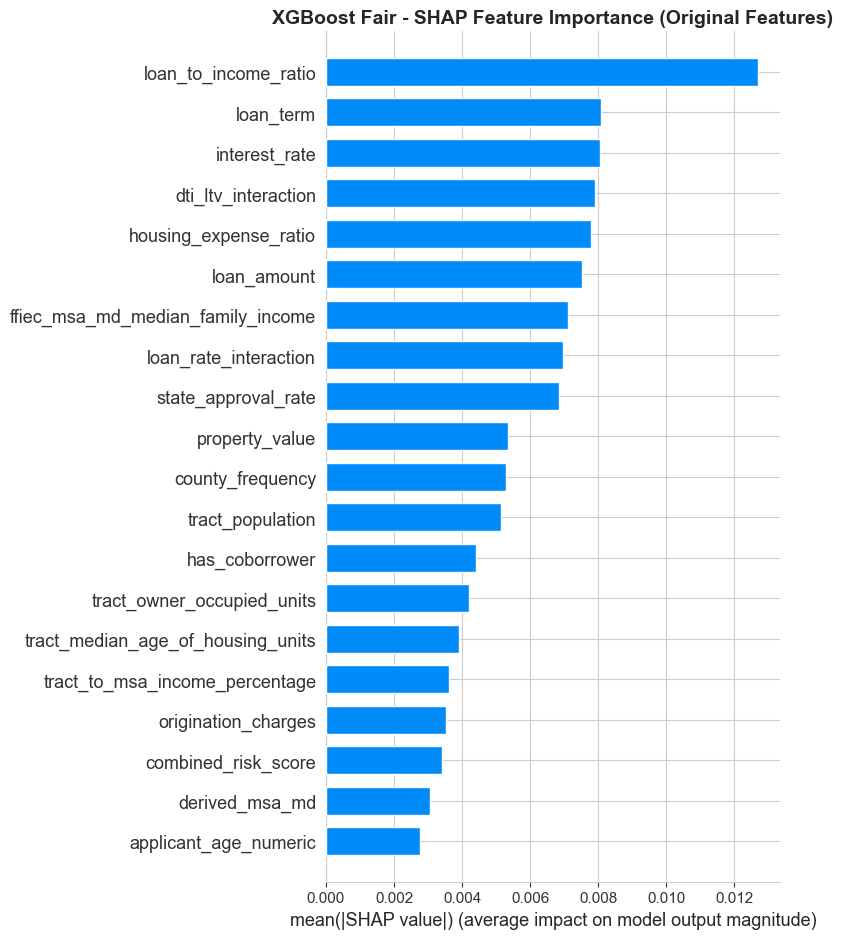


📊 Top 15 Most Important Original Features:
--------------------------------------------------


,feature,mean_abs_shap
0,loan_to_income_ratio,0.012711
1,loan_term,0.008090
2,interest_rate,0.008067
3,dti_ltv_interaction,0.007894
4,housing_expense_ratio,0.007785
5,loan_amount,0.007530
6,ffiec_msa_md_median_family_income,0.007126
7,loan_rate_interaction,0.006957
8,state_approval_rate,0.006848
9,property_value,0.005364


In [13]:
# ============================================================================
# SHAP SUMMARY PLOT - BAR (ORIGINAL FEATURE IMPORTANCE)
# ============================================================================

if 'XGBoost Fair' in composite_models:
    print("\n📊 SHAP Feature Importance - Fair Model (Original Features)\n")
    
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        xgb_fair_shap_values,
        X_explain,
        feature_names=original_feature_names_fair,
        plot_type='bar',
        max_display=20,
        show=False
    )
    plt.title('XGBoost Fair - SHAP Feature Importance (Original Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save plot
    plt.savefig('reports/figures/shap_feature_importance_fair_original.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved to reports/figures/shap_feature_importance_fair_original.png")
    plt.show()
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': original_feature_names_fair,
        'mean_abs_shap': np.abs(xgb_fair_shap_values).mean(axis=0)
    }).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
    
    print("\n📊 Top 15 Most Important Original Features:")
    print("-" * 50)
    display(importance_df.head(15))


📊 SHAP Beeswarm Plot (Original Feature Value vs Impact)

✅ Plot saved to reports/figures/shap_beeswarm_fair_original.png


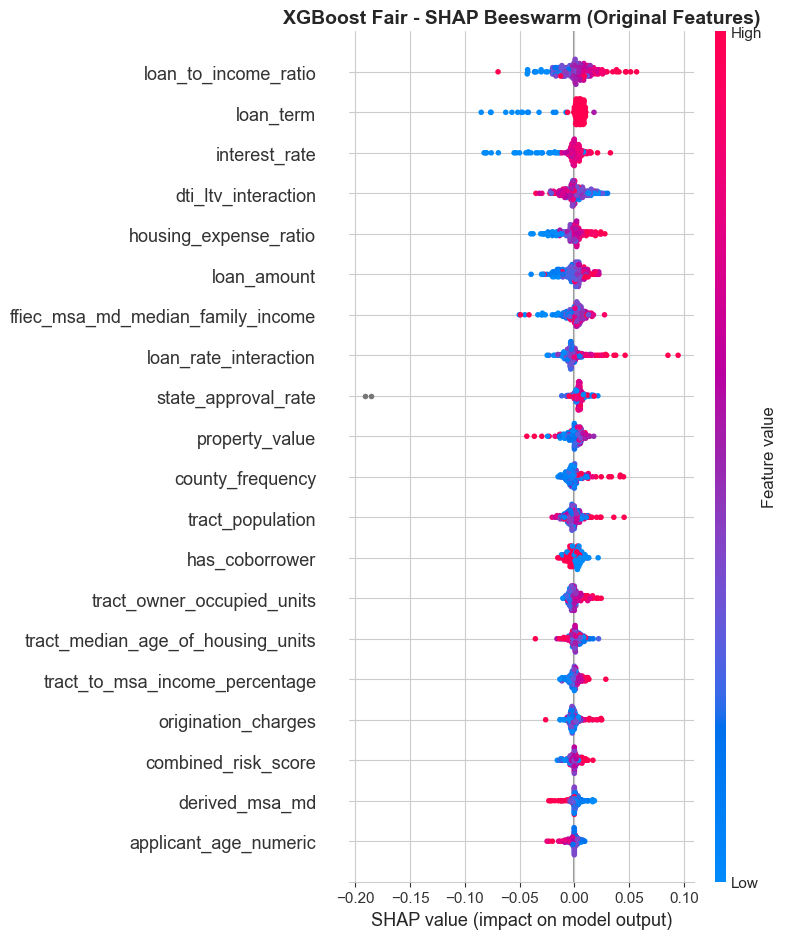

In [14]:
# ============================================================================
# SHAP SUMMARY PLOT - BEESWARM (ORIGINAL FEATURES)
# ============================================================================

if 'XGBoost Fair' in composite_models:
    print("\n📊 SHAP Beeswarm Plot (Original Feature Value vs Impact)\n")
    
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        xgb_fair_shap_values,
        X_explain,
        feature_names=original_feature_names_fair,
        max_display=20,
        show=False
    )
    plt.title('XGBoost Fair - SHAP Beeswarm (Original Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save plot
    plt.savefig('reports/figures/shap_beeswarm_fair_original.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved to reports/figures/shap_beeswarm_fair_original.png")
    plt.show()

In [15]:
# ============================================================================
# FEATURE IMPORTANCE RANKINGS - SAVE TO CSV
# ============================================================================

if 'XGBoost Fair' in composite_models:
    print("\n📊 Feature Importance Rankings (Original Features)\n")
    
    # Already computed importance_df above
    print("Top 20 Most Important Original Features:")
    print("-" * 50)
    display(importance_df.head(20))
    
    # Save to CSV
    importance_df.to_csv('results/feature_importance_fair_original.csv', index=False)
    print("\n✅ Feature importance saved to results/feature_importance_fair_original.csv")


📊 Feature Importance Rankings (Original Features)

Top 20 Most Important Original Features:
--------------------------------------------------


,feature,mean_abs_shap
0,loan_to_income_ratio,0.012711
1,loan_term,0.008090
2,interest_rate,0.008067
3,dti_ltv_interaction,0.007894
4,housing_expense_ratio,0.007785
5,loan_amount,0.007530
6,ffiec_msa_md_median_family_income,0.007126
7,loan_rate_interaction,0.006957
8,state_approval_rate,0.006848
9,property_value,0.005364



✅ Feature importance saved to results/feature_importance_fair_original.csv


PARTIAL DEPENDENCE PLOTS (ORIGINAL FEATURES)

Analyzing top features: ['loan_to_income_ratio', 'loan_term', 'interest_rate', 'dti_ltv_interaction']

✅ Plot saved to reports/figures/partial_dependence_plots_fair.png


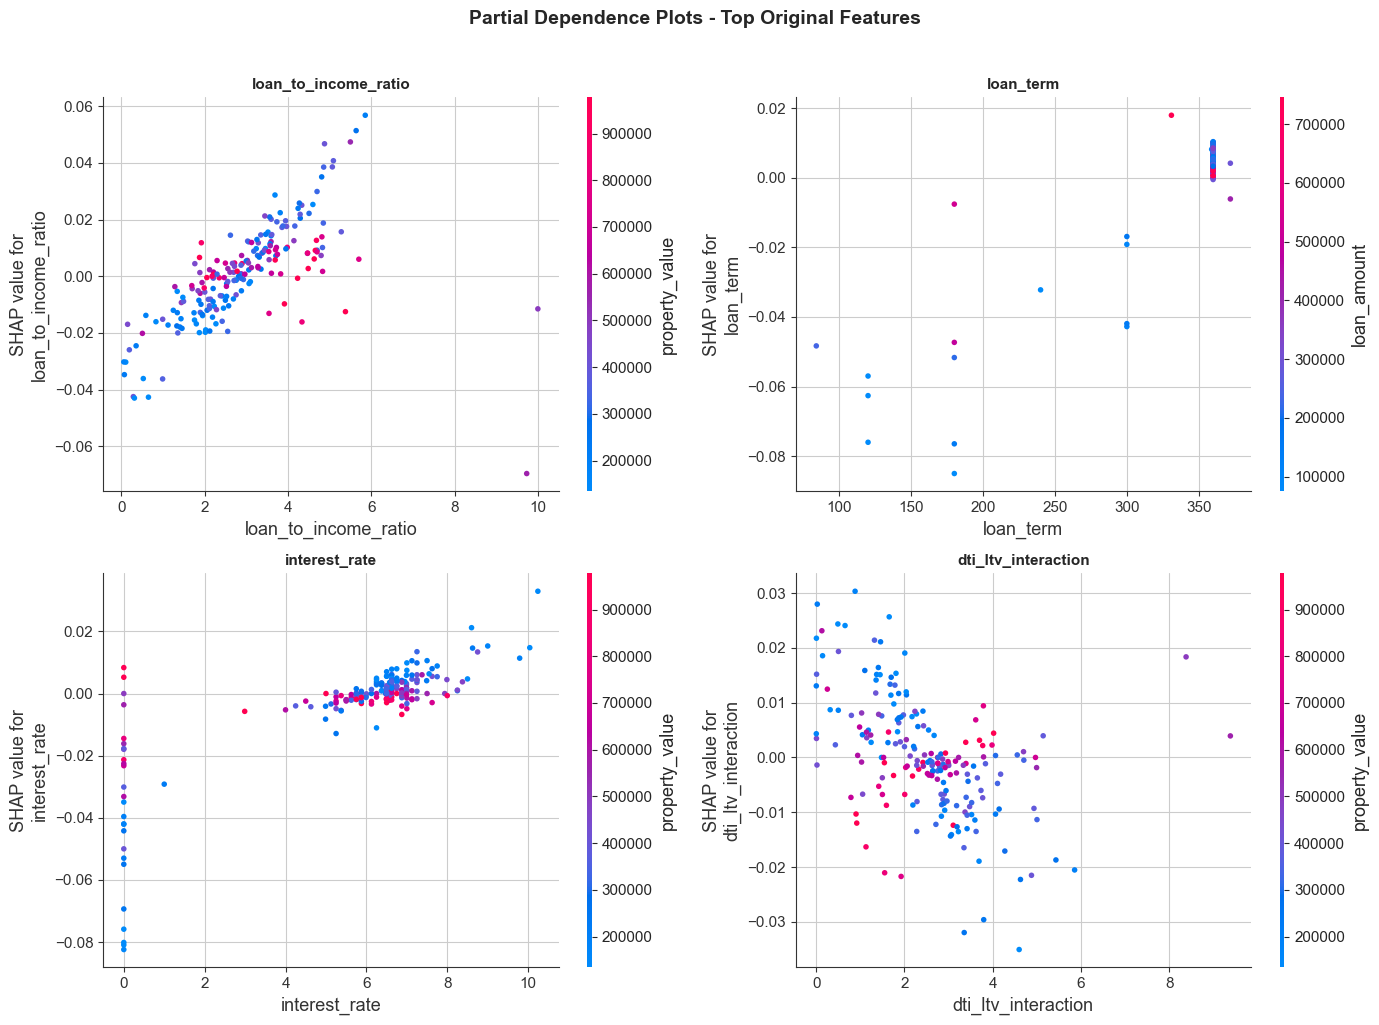

In [16]:
# ============================================================================
# PARTIAL DEPENDENCE PLOTS - KEY ORIGINAL FEATURES
# ============================================================================

if 'XGBoost Fair' in composite_models:
    print("="*80)
    print("PARTIAL DEPENDENCE PLOTS (ORIGINAL FEATURES)")
    print("="*80)
    
    # Get top 4 features for PDP
    top_features = importance_df['feature'].head(4).tolist()
    print(f"\nAnalyzing top features: {top_features}\n")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for idx, feature in enumerate(top_features):
        ax = axes[idx // 2, idx % 2]
        feat_idx = original_feature_names_fair.index(feature) if feature in original_feature_names_fair else idx
        
        # Create dependence plot
        shap.dependence_plot(
            feat_idx,
            xgb_fair_shap_values,
            X_explain,
            feature_names=original_feature_names_fair,
            interaction_index='auto',
            ax=ax,
            show=False
        )
        ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
    
    plt.suptitle('Partial Dependence Plots - Top Original Features', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    plt.savefig('reports/figures/partial_dependence_plots_fair.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved to reports/figures/partial_dependence_plots_fair.png")
    plt.show()

---
## Task 7.2: Local Interpretability

### Individual Prediction Explanations

Local interpretability helps understand why the model made a specific decision for an individual applicant.

---

In [17]:
# ============================================================================
# FIND EXAMPLE CASES (FAIR MODEL)
# ============================================================================

if 'XGBoost Fair' in composite_models:
    print("="*80)
    print("FINDING EXAMPLE CASES (FAIR MODEL)")
    print("="*80)
    
    # Get predictions on the explained samples using fair model
    y_explain = y_sample[:200]  # Same samples we computed SHAP for
    y_pred_proba_fair = composite_models['XGBoost Fair'].predict_proba(X_explain)[:, 1]
    y_pred_fair = (y_pred_proba_fair > 0.5).astype(int)
    
    # Find different case types
    approved_high_conf = np.where((y_pred_proba_fair > 0.85) & (y_explain == 1))[0]
    denied_high_conf = np.where((y_pred_proba_fair < 0.15) & (y_explain == 0))[0]
    borderline = np.where((y_pred_proba_fair > 0.4) & (y_pred_proba_fair < 0.6))[0]
    
    print(f"\nFound {len(approved_high_conf)} high-confidence approved cases")
    print(f"Found {len(denied_high_conf)} high-confidence denied cases")
    print(f"Found {len(borderline)} borderline cases")

FINDING EXAMPLE CASES (FAIR MODEL)

Found 158 high-confidence approved cases
Found 0 high-confidence denied cases
Found 1 borderline cases


WATERFALL PLOT - HIGH CONFIDENCE APPROVED

Sample Index: 0
Prediction: APPROVED (Fair Model)
Probability: 89.1%
Actual: Approved

✅ Plot saved to reports/figures/waterfall_approved_fair.png


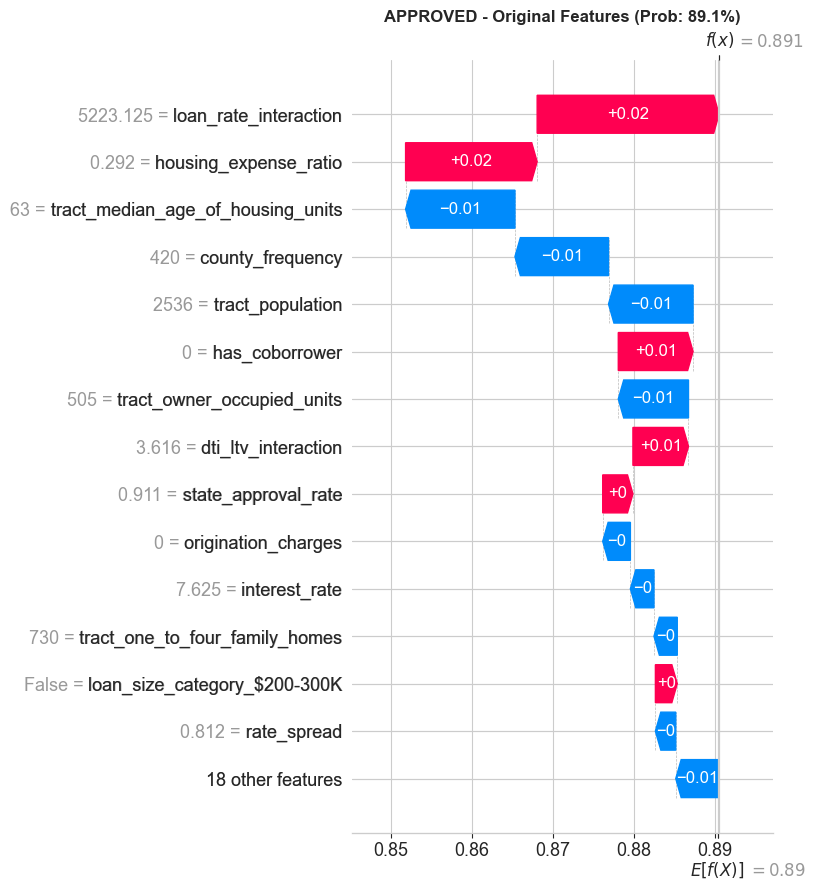

In [19]:
# ============================================================================
# WATERFALL PLOT - APPROVED CASE (ORIGINAL FEATURES)
# ============================================================================

if 'XGBoost Fair' in composite_models and len(approved_high_conf) > 0:
    print("="*80)
    print("WATERFALL PLOT - HIGH CONFIDENCE APPROVED")
    print("="*80)
    
    example_idx = approved_high_conf[0]
    prob = y_pred_proba_fair[example_idx]
    
    print(f"\nSample Index: {example_idx}")
    print(f"Prediction: APPROVED (Fair Model)")
    print(f"Probability: {prob:.1%}")
    print(f"Actual: {'Approved' if y_explain[example_idx] == 1 else 'Denied'}")
    print()
    
    # Get expected value and ensure it's a scalar
    expected_value = xgb_fair_explainer.expected_value
    if isinstance(expected_value, (list, np.ndarray)):
        expected_value = float(expected_value[1])  # Class 1 (approved)
    else:
        expected_value = float(expected_value)
    
    explanation_obj = shap.Explanation(
        values=xgb_fair_shap_values[example_idx],
        base_values=expected_value,
        data=X_explain[example_idx],
        feature_names=original_feature_names_fair
    )
    
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(explanation_obj, max_display=15, show=False)
    plt.title(f'APPROVED - Original Features (Prob: {prob:.1%})', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('reports/figures/waterfall_approved_fair.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved to reports/figures/waterfall_approved_fair.png")
    plt.show()

In [22]:
# ============================================================================
# WATERFALL PLOT - DENIED CASE (ORIGINAL FEATURES)
# ============================================================================

if 'XGBoost Fair' in composite_models and len(denied_high_conf) > 0:
    print("="*80)
    print("WATERFALL PLOT - HIGH CONFIDENCE DENIED")
    print("="*80)
    
    example_idx = denied_high_conf[0]
    prob = y_pred_proba_fair[example_idx]
    
    print(f"\nSample Index: {example_idx}")
    print(f"Prediction: DENIED (Fair Model)")
    print(f"Probability: {prob:.1%}")
    print(f"Actual: {'Approved' if y_explain[example_idx] == 1 else 'Denied'}")
    print()
    
    # Get expected value and ensure it's a scalar
    expected_value = xgb_fair_explainer.expected_value
    if isinstance(expected_value, (list, np.ndarray)):
        expected_value = float(expected_value[1])  # Class 1 (approved)
    else:
        expected_value = float(expected_value)
    
    explanation_obj = shap.Explanation(
        values=xgb_fair_shap_values[example_idx],
        base_values=expected_value,
        data=X_explain[example_idx],
        feature_names=original_feature_names_fair
    )
    
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(explanation_obj, max_display=15, show=False)
    plt.title(f'DENIED - Original Features (Prob: {prob:.1%})', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('reports/figures/waterfall_denied_fair.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved to reports/figures/waterfall_denied_fair.png")
    plt.show()

WATERFALL PLOT - BORDERLINE CASE

Sample Index: 140
Prediction: APPROVED (Fair Model)
Probability: 52.5%
Actual: Denied

✅ Plot saved to reports/figures/waterfall_borderline_fair.png


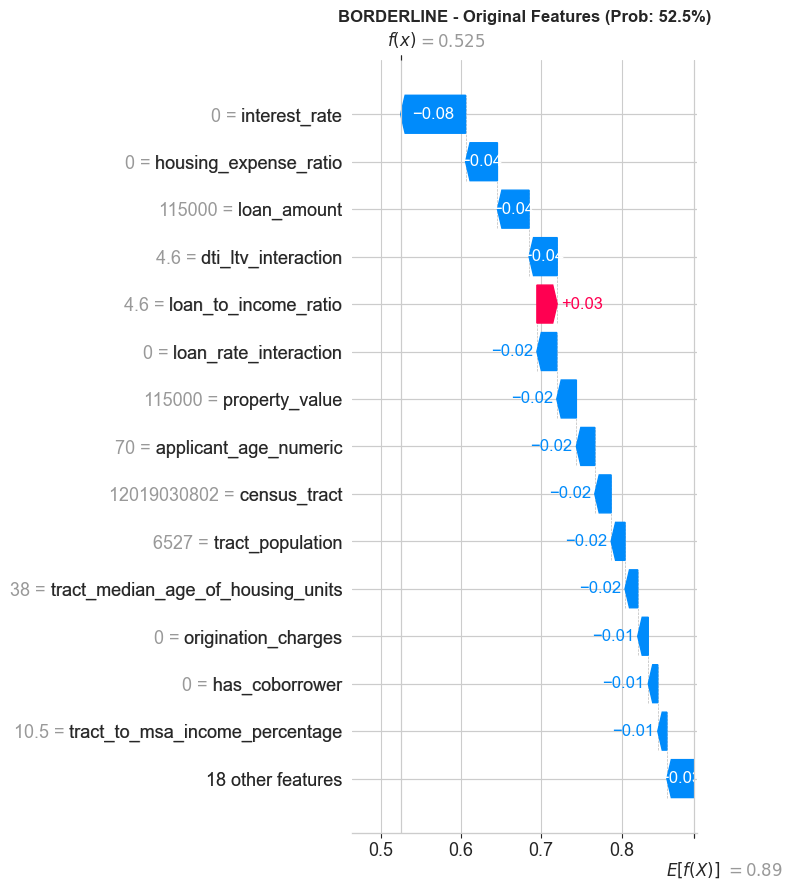

In [23]:
# ============================================================================
# WATERFALL PLOT - BORDERLINE CASE (ORIGINAL FEATURES)
# ============================================================================

if 'XGBoost Fair' in composite_models and len(borderline) > 0:
    print("="*80)
    print("WATERFALL PLOT - BORDERLINE CASE")
    print("="*80)
    
    example_idx = borderline[0]
    prob = y_pred_proba_fair[example_idx]
    
    print(f"\nSample Index: {example_idx}")
    print(f"Prediction: {'APPROVED' if prob > 0.5 else 'DENIED'} (Fair Model)")
    print(f"Probability: {prob:.1%}")
    print(f"Actual: {'Approved' if y_explain[example_idx] == 1 else 'Denied'}")
    print()
    
    # Get expected value and ensure it's a scalar
    expected_value = xgb_fair_explainer.expected_value
    if isinstance(expected_value, (list, np.ndarray)):
        expected_value = float(expected_value[1])  # Class 1 (approved)
    else:
        expected_value = float(expected_value)
    
    explanation_obj = shap.Explanation(
        values=xgb_fair_shap_values[example_idx],
        base_values=expected_value,
        data=X_explain[example_idx],
        feature_names=original_feature_names_fair
    )
    
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(explanation_obj, max_display=15, show=False)
    plt.title(f'BORDERLINE - Original Features (Prob: {prob:.1%})', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('reports/figures/waterfall_borderline_fair.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved to reports/figures/waterfall_borderline_fair.png")
    plt.show()

SHAP FORCE PLOT (ORIGINAL FEATURES)


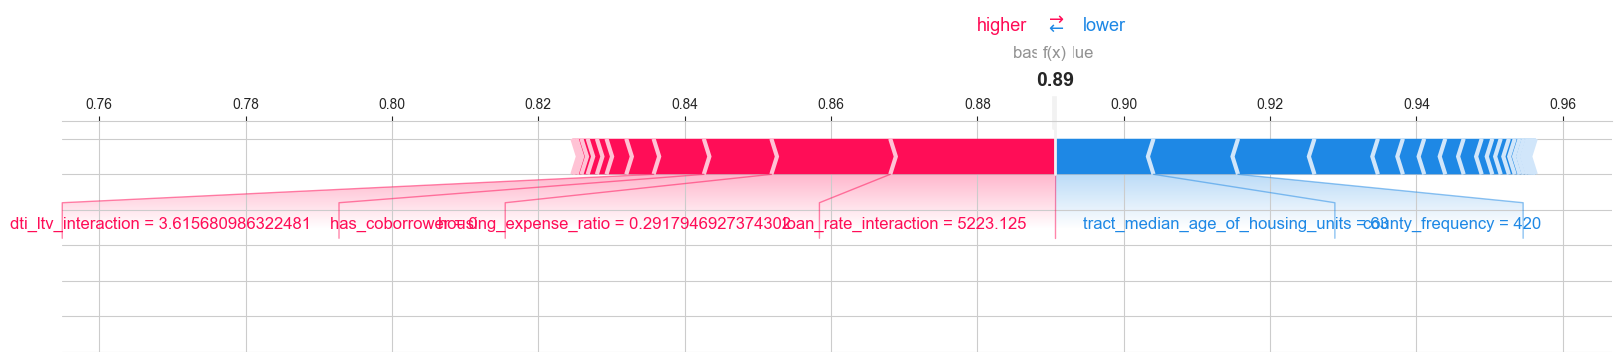


✅ Force plot saved to reports/figures/force_plot_fair.png


In [24]:
# ============================================================================
# FORCE PLOT - INDIVIDUAL PREDICTION (ORIGINAL FEATURES)
# ============================================================================

if 'XGBoost Fair' in composite_models and len(approved_high_conf) > 0:
    print("="*80)
    print("SHAP FORCE PLOT (ORIGINAL FEATURES)")
    print("="*80)
    
    example_idx = approved_high_conf[0]
    
    # Get expected value and ensure it's a scalar
    expected_value = xgb_fair_explainer.expected_value
    if isinstance(expected_value, (list, np.ndarray)):
        expected_value = float(expected_value[1])  # Class 1 (approved)
    else:
        expected_value = float(expected_value)
    
    # Create force plot with original feature names
    shap.force_plot(
        expected_value,
        xgb_fair_shap_values[example_idx],
        X_explain[example_idx],
        feature_names=original_feature_names_fair,
        matplotlib=True,
        show=True
    )
    
    plt.savefig('reports/figures/force_plot_fair.png', dpi=150, bbox_inches='tight')
    print("\n✅ Force plot saved to reports/figures/force_plot_fair.png")

---
## Task 7.3: Human-Readable Explanations

### Underwriter-Friendly Explanation Generation

Generate human-readable explanations that can be used by underwriters to understand model decisions.

---

In [25]:
# ============================================================================
# GENERATE HUMAN EXPLANATIONS - ORIGINAL FEATURES
# ============================================================================

def generate_human_explanation_from_shap(shap_values, feature_names, feature_values, 
                                          probability, top_k=5):
    """Generate human-readable explanation from SHAP values."""
    
    # Sort features by absolute SHAP value
    sorted_indices = np.argsort(np.abs(shap_values))[::-1]
    
    # Determine prediction
    if probability > 0.7:
        decision = "APPROVED (High Confidence)"
    elif probability > 0.5:
        decision = "APPROVED (Moderate Confidence)"
    elif probability > 0.3:
        decision = "DENIED (Moderate Confidence)"
    else:
        decision = "DENIED (High Confidence)"
    
    explanation = f"""
================================================================================
LOAN DECISION EXPLANATION (Fair Model with Original Features)
================================================================================

DECISION: {decision}
APPROVAL PROBABILITY: {probability:.1%}

TOP FACTORS INFLUENCING THIS DECISION:
--------------------------------------
"""
    
    for i in range(min(top_k, len(sorted_indices))):
        idx = sorted_indices[i]
        feature = feature_names[idx]
        shap_val = shap_values[idx]
        feat_val = feature_values[idx]
        
        direction = "↑ INCREASES" if shap_val > 0 else "↓ DECREASES"
        explanation += f"  {i+1}. {feature}: {direction} approval likelihood\n"
        explanation += f"     Value: {feat_val:.4g}, Impact: {shap_val:+.4f}\n\n"
    
    return explanation

if 'XGBoost Fair' in composite_models:
    print("="*80)
    print("HUMAN-READABLE EXPLANATIONS (ORIGINAL FEATURES)")
    print("="*80)
    
    # Approved case
    if len(approved_high_conf) > 0:
        idx = approved_high_conf[0]
        explanation = generate_human_explanation_from_shap(
            xgb_fair_shap_values[idx],
            original_feature_names_fair,
            X_explain[idx],
            y_pred_proba_fair[idx]
        )
        print(explanation)
    
    # Denied case
    if len(denied_high_conf) > 0:
        idx = denied_high_conf[0]
        explanation = generate_human_explanation_from_shap(
            xgb_fair_shap_values[idx],
            original_feature_names_fair,
            X_explain[idx],
            y_pred_proba_fair[idx]
        )
        print(explanation)
    
    # Borderline case
    if len(borderline) > 0:
        idx = borderline[0]
        explanation = generate_human_explanation_from_shap(
            xgb_fair_shap_values[idx],
            original_feature_names_fair,
            X_explain[idx],
            y_pred_proba_fair[idx]
        )
        print(explanation)

HUMAN-READABLE EXPLANATIONS (ORIGINAL FEATURES)

LOAN DECISION EXPLANATION (Fair Model with Original Features)

DECISION: APPROVED (High Confidence)
APPROVAL PROBABILITY: 89.1%

TOP FACTORS INFLUENCING THIS DECISION:
--------------------------------------
  1. loan_rate_interaction: ↑ INCREASES approval likelihood
     Value: 5223, Impact: +0.0225

  2. housing_expense_ratio: ↑ INCREASES approval likelihood
     Value: 0.2918, Impact: +0.0162

  3. tract_median_age_of_housing_units: ↓ DECREASES approval likelihood
     Value: 63, Impact: -0.0135

  4. county_frequency: ↓ DECREASES approval likelihood
     Value: 420, Impact: -0.0116

  5. tract_population: ↓ DECREASES approval likelihood
     Value: 2536, Impact: -0.0104



LOAN DECISION EXPLANATION (Fair Model with Original Features)

DECISION: APPROVED (Moderate Confidence)
APPROVAL PROBABILITY: 52.5%

TOP FACTORS INFLUENCING THIS DECISION:
--------------------------------------
  1. interest_rate: ↓ DECREASES approval likelihood
   

In [26]:
# ============================================================================
# DETAILED EXPLANATION DICTIONARY
# ============================================================================

if 'XGBoost Fair' in composite_models and len(approved_high_conf) > 0:
    print("="*80)
    print("DETAILED EXPLANATION DICTIONARY (ORIGINAL FEATURES)")
    print("="*80)
    
    idx = approved_high_conf[0]
    shap_vals = xgb_fair_shap_values[idx]
    
    # Get expected value and ensure it's a scalar
    expected_value = xgb_fair_explainer.expected_value
    if isinstance(expected_value, (list, np.ndarray)):
        expected_value = float(expected_value[1])  # Class 1 (approved)
    else:
        expected_value = float(expected_value)
    
    # Sort by absolute SHAP value
    sorted_indices = np.argsort(np.abs(shap_vals))[::-1]
    
    # Build explanation dictionary
    detailed_explanation = {
        'prediction': 'Approved' if y_pred_proba_fair[idx] > 0.5 else 'Denied',
        'probability': y_pred_proba_fair[idx],
        'confidence': abs(y_pred_proba_fair[idx] - 0.5) * 200,
        'expected_value': expected_value,
        'top_positive_factors': [],
        'top_negative_factors': []
    }
    
    for i in sorted_indices[:10]:
        factor = {
            'feature': original_feature_names_fair[i],
            'shap_value': shap_vals[i],
            'feature_value': X_explain[idx, i]
        }
        if shap_vals[i] > 0:
            detailed_explanation['top_positive_factors'].append(factor)
        else:
            detailed_explanation['top_negative_factors'].append(factor)
    
    print("\nExplanation Structure:")
    print("-" * 40)
    print(f"Prediction: {detailed_explanation['prediction']}")
    print(f"Probability: {detailed_explanation['probability']:.1%}")
    print(f"Confidence: {detailed_explanation['confidence']:.0f}%")
    print(f"Base Value: {detailed_explanation['expected_value']:.4f}")
    
    print("\nTop Positive Factors (Original Features):")
    for factor in detailed_explanation['top_positive_factors'][:5]:
        print(f"  • {factor['feature']}: SHAP={factor['shap_value']:.4f}, Value={factor['feature_value']:.4g}")
    
    print("\nTop Negative Factors (Original Features):")
    for factor in detailed_explanation['top_negative_factors'][:5]:
        print(f"  • {factor['feature']}: SHAP={factor['shap_value']:.4f}, Value={factor['feature_value']:.4g}")

DETAILED EXPLANATION DICTIONARY (ORIGINAL FEATURES)

Explanation Structure:
----------------------------------------
Prediction: Approved
Probability: 89.1%
Confidence: 78%
Base Value: 0.8904

Top Positive Factors (Original Features):
  • loan_rate_interaction: SHAP=0.0225, Value=5223
  • housing_expense_ratio: SHAP=0.0162, Value=0.2918
  • has_coborrower: SHAP=0.0092, Value=0
  • dti_ltv_interaction: SHAP=0.0069, Value=3.616
  • state_approval_rate: SHAP=0.0037, Value=0.9108

Top Negative Factors (Original Features):
  • tract_median_age_of_housing_units: SHAP=-0.0135, Value=63
  • county_frequency: SHAP=-0.0116, Value=420
  • tract_population: SHAP=-0.0104, Value=2536
  • tract_owner_occupied_units: SHAP=-0.0087, Value=505
  • origination_charges: SHAP=-0.0034, Value=0


---
## Task 7.4: Latent-to-Original Feature Mapping Analysis

### Visualize How Latent Features Map to Original Features

Understanding the encoder's learned representations.

---

LATENT TO ORIGINAL FEATURE MAPPING VISUALIZATION
✅ Plot saved to reports/figures/latent_to_original_mapping.png


<Figure size 1200x600 with 0 Axes>

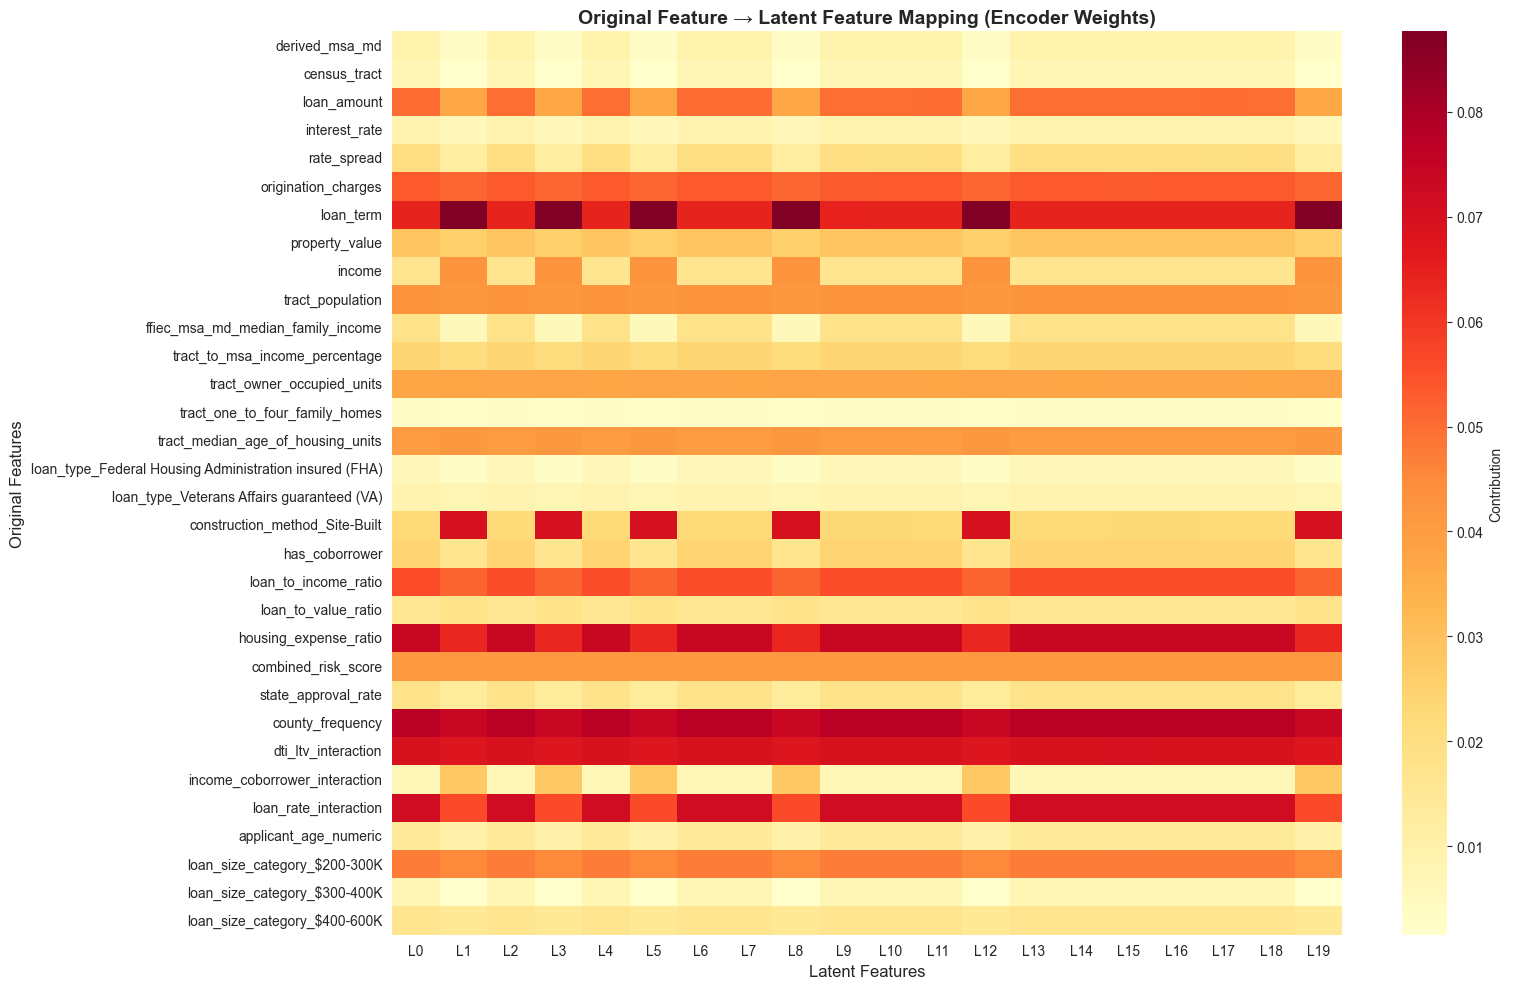


📊 Key Latent Features and Top Original Contributors:
------------------------------------------------------------

latent_0:
  • county_frequency: 0.077
  • housing_expense_ratio: 0.074
  • loan_rate_interaction: 0.072

latent_1:
  • loan_term: 0.088
  • county_frequency: 0.074
  • construction_method_Site-Built: 0.070

latent_2:
  • county_frequency: 0.077
  • housing_expense_ratio: 0.074
  • loan_rate_interaction: 0.072

latent_3:
  • loan_term: 0.088
  • county_frequency: 0.074
  • construction_method_Site-Built: 0.070

latent_4:
  • county_frequency: 0.077
  • housing_expense_ratio: 0.074
  • loan_rate_interaction: 0.072


In [27]:
# ============================================================================
# VISUALIZE LATENT-TO-ORIGINAL FEATURE MAPPING
# ============================================================================

print("="*80)
print("LATENT TO ORIGINAL FEATURE MAPPING VISUALIZATION")
print("="*80)

# Create heatmap of feature-to-latent contributions
plt.figure(figsize=(16, 10))

# Use first 20 latent features and all original features
n_show_latent = min(20, n_latent)
n_show_orig = min(32, n_orig)

mapping_matrix = feature_to_latent_importance[:n_show_orig, :n_show_latent]

sns.heatmap(
    mapping_matrix,
    xticklabels=[f'L{i}' for i in range(n_show_latent)],
    yticklabels=selected_features[:n_show_orig],
    cmap='YlOrRd',
    fmt='.2f',
    cbar_kws={'label': 'Contribution'}
)
plt.xlabel('Latent Features', fontsize=12)
plt.ylabel('Original Features', fontsize=12)
plt.title('Original Feature → Latent Feature Mapping (Encoder Weights)', fontsize=14, fontweight='bold')
plt.tight_layout()

plt.savefig('reports/figures/latent_to_original_mapping.png', dpi=150, bbox_inches='tight')
print("✅ Plot saved to reports/figures/latent_to_original_mapping.png")
plt.show()

# Show top contributors for key latent features
print("\n📊 Key Latent Features and Top Original Contributors:")
print("-" * 60)
for latent_idx in range(min(5, n_latent)):
    latent_name = f'latent_{latent_idx}'
    if latent_name in latent_to_original_mapping:
        top_3 = latent_to_original_mapping[latent_name][:3]
        print(f"\n{latent_name}:")
        for feat, contrib in top_3:
            print(f"  • {feat}: {contrib:.3f}")

ENCODER WEIGHTS VS SHAP IMPORTANCE COMPARISON
✅ Plot saved to reports/figures/encoder_vs_shap_importance.png


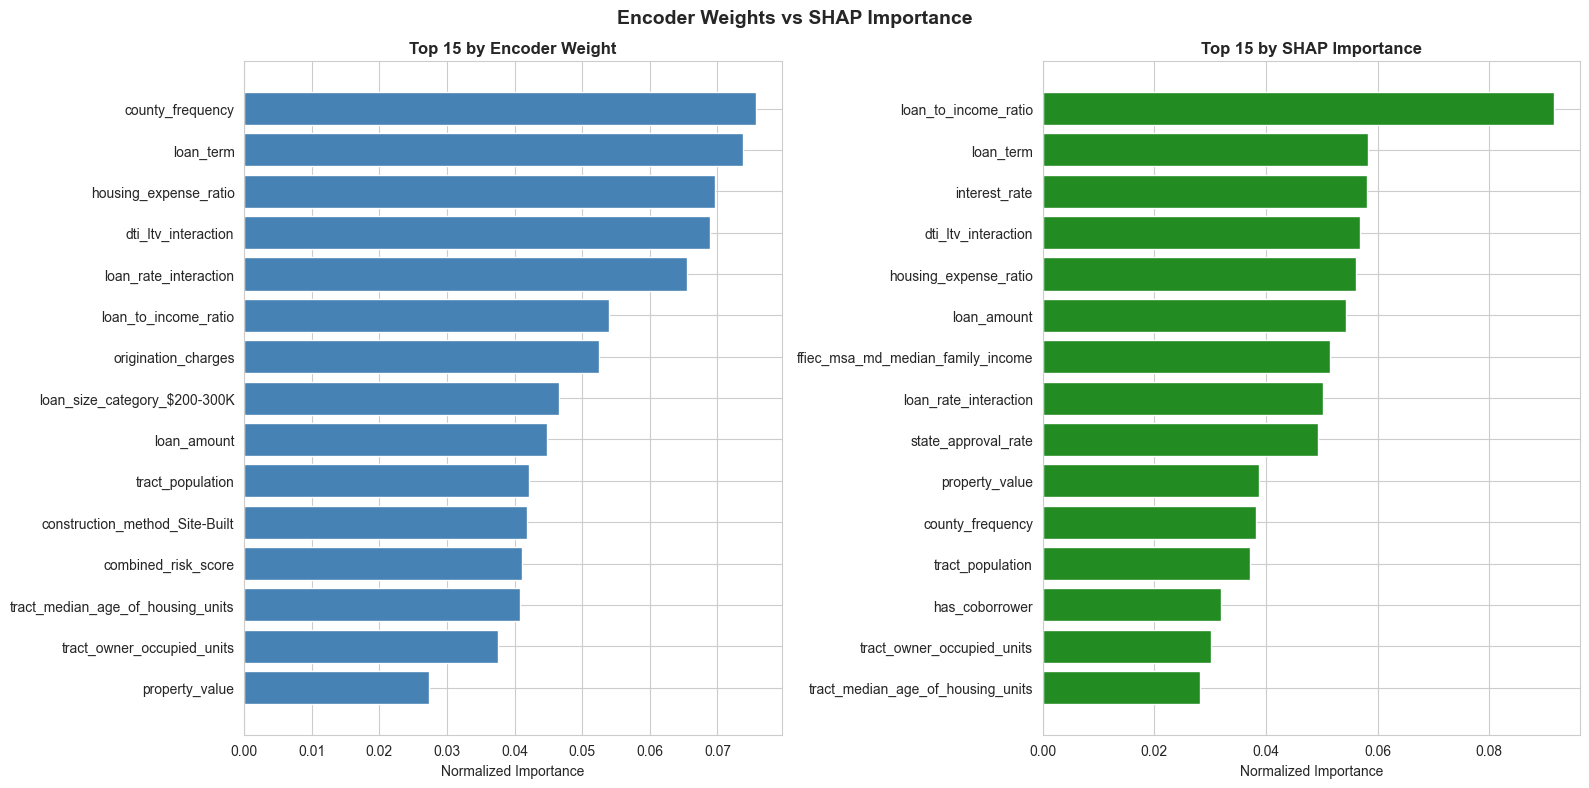


📊 Correlation between Encoder Weights and SHAP: 0.538


In [28]:
# ============================================================================
# COMPARE ENCODER WEIGHTS VS SHAP IMPORTANCE
# ============================================================================

print("="*80)
print("ENCODER WEIGHTS VS SHAP IMPORTANCE COMPARISON")
print("="*80)

# Merge encoder importance with SHAP importance
if 'XGBoost Fair' in composite_models:
    # Get common features
    comparison_df = original_importance_df.copy()
    comparison_df = comparison_df.rename(columns={'encoder_importance': 'encoder_weight'})
    
    # Add SHAP importance
    shap_imp = importance_df.set_index('feature')['mean_abs_shap']
    comparison_df['shap_importance'] = comparison_df['feature'].map(shap_imp)
    comparison_df = comparison_df.dropna()
    
    # Normalize for comparison
    comparison_df['encoder_weight_norm'] = comparison_df['encoder_weight'] / comparison_df['encoder_weight'].sum()
    comparison_df['shap_importance_norm'] = comparison_df['shap_importance'] / comparison_df['shap_importance'].sum()
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top by encoder weights
    ax1 = axes[0]
    top_by_encoder = comparison_df.nlargest(15, 'encoder_weight_norm')
    ax1.barh(top_by_encoder['feature'], top_by_encoder['encoder_weight_norm'], color='steelblue')
    ax1.set_xlabel('Normalized Importance')
    ax1.set_title('Top 15 by Encoder Weight', fontweight='bold')
    ax1.invert_yaxis()
    
    # Top by SHAP
    ax2 = axes[1]
    top_by_shap = comparison_df.nlargest(15, 'shap_importance_norm')
    ax2.barh(top_by_shap['feature'], top_by_shap['shap_importance_norm'], color='forestgreen')
    ax2.set_xlabel('Normalized Importance')
    ax2.set_title('Top 15 by SHAP Importance', fontweight='bold')
    ax2.invert_yaxis()
    
    plt.suptitle('Encoder Weights vs SHAP Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig('reports/figures/encoder_vs_shap_importance.png', dpi=150, bbox_inches='tight')
    print("✅ Plot saved to reports/figures/encoder_vs_shap_importance.png")
    plt.show()
    
    # Correlation
    corr = comparison_df['encoder_weight_norm'].corr(comparison_df['shap_importance_norm'])
    print(f"\n📊 Correlation between Encoder Weights and SHAP: {corr:.3f}")

In [29]:
# ============================================================================
# SAVE LATENT-TO-ORIGINAL MAPPING
# ============================================================================

print("="*80)
print("SAVING LATENT-TO-ORIGINAL FEATURE MAPPING")
print("="*80)

# Create detailed mapping dataframe
mapping_records = []
for latent_name, contributors in latent_to_original_mapping.items():
    for rank, (feature, contribution) in enumerate(contributors, 1):
        mapping_records.append({
            'latent_feature': latent_name,
            'rank': rank,
            'original_feature': feature,
            'contribution': contribution
        })

mapping_df = pd.DataFrame(mapping_records)
mapping_df.to_csv('results/latent_to_original_mapping.csv', index=False)
print(f"✅ Mapping saved to results/latent_to_original_mapping.csv")
print(f"   Total mappings: {len(mapping_df)}")

# Display sample
print("\nSample of Latent-to-Original Mapping:")
print("-" * 60)
display(mapping_df.head(15))

SAVING LATENT-TO-ORIGINAL FEATURE MAPPING
✅ Mapping saved to results/latent_to_original_mapping.csv
   Total mappings: 320

Sample of Latent-to-Original Mapping:
------------------------------------------------------------


,latent_feature,rank,original_feature,contribution
0,latent_0,1,county_frequency,0.077103
1,latent_0,2,housing_expense_ratio,0.073601
2,latent_0,3,loan_rate_interaction,0.071789
3,latent_0,4,dti_ltv_interaction,0.069377
4,latent_0,5,loan_term,0.064344
5,latent_1,1,loan_term,0.087651
6,latent_1,2,county_frequency,0.073588
7,latent_1,3,construction_method_Site-Built,0.069709
8,latent_1,4,dti_ltv_interaction,0.068098
9,latent_1,5,housing_expense_ratio,0.063733


---
## Summary and Key Findings

---

In [30]:
# ============================================================================
# SUMMARY REPORT
# ============================================================================

print("="*80)
print("PHASE 7 SUMMARY: MODEL EXPLAINABILITY")
print("="*80)

print("\n🎯 FAIR MODELS ANALYZED (WITH ORIGINAL FEATURE MAPPING):")
print("-" * 50)
for model_name in fair_models.keys():
    print(f"  ✅ {model_name}")

print("\n🔗 LATENT-TO-ORIGINAL FEATURE MAPPING:")
print("-" * 50)
print(f"✅ Created mapping via encoder weights analysis")
print(f"   Original features: {len(selected_features)}")
print(f"   Latent features: {len(latent_features)}")
print(f"✅ SHAP computed through composite pipeline")
print(f"   Explanations use ORIGINAL feature names!")

print("\n📊 GLOBAL INTERPRETABILITY:")
print("-" * 50)
if 'XGBoost Fair' in composite_models:
    print(f"✅ SHAP summary plots with original features")
    print(f"✅ Feature importance rankings:")
    for i, row in importance_df.head(5).iterrows():
        print(f"   {i+1}. {row['feature']}: {row['mean_abs_shap']:.4f}")
    print(f"✅ Partial dependence plots created")

print("\n📋 LOCAL INTERPRETABILITY:")
print("-" * 50)
print(f"✅ Waterfall plots with original feature names")
print(f"✅ Force plots for individual predictions")
print(f"✅ Human-readable explanations generated")

print("\n📁 SAVED ARTIFACTS:")
print("-" * 50)
print("   reports/figures/")
print("   ├── shap_feature_importance_fair_original.png")
print("   ├── shap_beeswarm_fair_original.png")
print("   ├── partial_dependence_plots_fair.png")
print("   ├── waterfall_approved_fair.png")
print("   ├── waterfall_denied_fair.png")
print("   ├── waterfall_borderline_fair.png")
print("   ├── force_plot_fair.png")
print("   ├── latent_to_original_mapping.png")
print("   └── encoder_vs_shap_importance.png")
print("   results/")
print("   ├── feature_importance_fair_original.csv")
print("   └── latent_to_original_mapping.csv")

print("\n" + "="*80)
print("✅ PHASE 7 COMPLETE: Fair Model Explainability with Original Features")
print("="*80)
print("\n💡 KEY ACHIEVEMENT:")
print("   Fair models use latent representations for fairness,")
print("   but explanations are now mapped back to ORIGINAL feature names")
print("   for human interpretability!")

PHASE 7 SUMMARY: MODEL EXPLAINABILITY

🎯 FAIR MODELS ANALYZED (WITH ORIGINAL FEATURE MAPPING):
--------------------------------------------------
  ✅ XGBoost Fair
  ✅ NN Fair
  ✅ GOSDT Fair
  ✅ FasterRisk Fair

🔗 LATENT-TO-ORIGINAL FEATURE MAPPING:
--------------------------------------------------
✅ Created mapping via encoder weights analysis
   Original features: 52
   Latent features: 64
✅ SHAP computed through composite pipeline
   Explanations use ORIGINAL feature names!

📊 GLOBAL INTERPRETABILITY:
--------------------------------------------------
✅ SHAP summary plots with original features
✅ Feature importance rankings:
   1. loan_to_income_ratio: 0.0127
   2. loan_term: 0.0081
   3. interest_rate: 0.0081
   4. dti_ltv_interaction: 0.0079
   5. housing_expense_ratio: 0.0078
✅ Partial dependence plots created

📋 LOCAL INTERPRETABILITY:
--------------------------------------------------
✅ Waterfall plots with original feature names
✅ Force plots for individual predictions
✅ Human